<p align="center"><b>Telecom Company Churn Prediction</b></p>

<p align="center">Hanjian Xu</p>
<p align="center">August 2024</p>

---

## Goal
This project aims to accurately predict customer churn for a telecom company by developing and optimizing machine learning models on an exisiting customer dataset.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prepare libraries/modules needed
# !pip install python-dotenv > /dev/null 2>&1
!pip install shap > /dev/null 2>&1

import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%cd '/content/drive/MyDrive/2_tele_customer_churn'

# Set the style for the matploftlib library
plt.style.use('ggplot')
height = 6
aspect = 8 / height

/content/drive/MyDrive/2_tele_customer_churn


## 1. Data Preparation

### 1.1 Loading the dataset.

In [ ]:
df = pd.read_csv('data/customer_churn.csv')
df.head()

# Checking missing data
df.isnull().sum()

,0
Call Failure,0
Complaints,0
Subscription Length,0
Charge Amount,0
Seconds of Use,0
Frequency of use,0
Frequency of SMS,0
Distinct Called Numbers,0
Age Group,0
Tariff Plan,0


In [ ]:
# overview of the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complaints               3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [ ]:
# Check label counts (churn vs. non-churn)
df['Churn'].value_counts()

,count
Churn,
0,2655
1,495


### 1.2 Data Overview

*Source: Iranian Churn Dataset. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5JW3Z.*

This dataset was randomly collected from an Iranian telecom company's database over a period of 12 months.
- Comprises information for 3150 customers.
- Each customer (row) is represented by 13 attributes, including a pre-calculated `Customer Value`.
- All attributes except for `Churn` are aggregated data of the first 9 months. The `Churn` labels are the state of the customers at the end of 12 months.

A detailed description of each feature/label is listed below:


| Feature                | Type       | Description    |
|------------------------|------------|--------------------------------------------------|
| `Call Failure`         | Continuous | Number of call failures.                         |
| `Complaints`           | Binary     | 0: No complaint, 1: complaint.  |
| `Subscription Length`  | Continuous | Length of subscription in months.                |
| `Charge Amount`        | Category | Ordinal attribute (0: lowest amount, 9: highest amount)                |
| `Seconds of Use`       | Continuous | Total seconds of calls.          |
| `Frequency of use`     | Continuous | Total number of calls.                      |
| `Frequency of SMS`     | Continuous | Total number of text messages.                          |
| `Distinct Called Numbers` | Continuous | Total number of distinct phone calls.
| `Age Group`            | Category   | Ordinal attribute (1: younger age, 5: older age)|
| `Tariff Plan`          | Binary   | Plan type (1: Pay as you go, 2: contractual)                    |
| `Status`               | Binary   | Customer status (1: active, 2: non-active)                          |
| `Age`                  | Continuous | Age of the customer.                             |
| `Customer Value`       | Continuous | Calculated value of the customer.                           |
| `Churn`                | Binary     | Class label (1: churn, 0: non-churn)     |


In [ ]:
# extract numerical feature names
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Descriptive statistics for numerical features
df[numeric_features].describe()

# reform the column names (using all lower cases and replace whitespace with _)
df.columns = df.columns.str.replace(' ', '_').str.lower()

# reform binary variables (1, 2) to (0, 1).
df['status'] = df['status'] - 1
df['tariff_plan'] = df['tariff_plan'] - 1

df.head()

,call_failure,complaints,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
0,8,0,38,0.0,4370,71,5,17,2.0,-1,-1,30,197.640,0
1,0,0,39,0.0,318,5,7,4,1.0,-1,0,25,46.035,0
2,10,0,37,0.0,2453,60,359,24,2.0,-1,-1,30,1536.520,0
3,10,0,38,0.0,4198,66,1,35,0.0,-1,-1,15,240.020,0
4,3,0,38,0.0,2393,58,2,33,0.0,-1,-1,15,145.805,0


In [ ]:
# Outlier exclusion function (Excluding values that are out of the 1.5 * IQR range below Q1 and Q3.)
def exclude_outliers_iqr(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered


In [ ]:
# Explicitly transform the two ordinal variables.
from sklearn.preprocessing import OrdinalEncoder

df['age_group'] = pd.Categorical(df['age_group'], categories=[1, 2, 3, 4, 5], ordered=True)

# Convert 'Charge Amount' to an ordered categorical variable
df['charge_amount'] = pd.Categorical(df['charge_amount'], categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True)

# Apply ordinal encoding to 'Age Group' and 'Charge Amount'
ordinal_encoder = OrdinalEncoder()
df[['age_group', 'charge_amount']] = ordinal_encoder.fit_transform(df[['age_group', 'charge_amount']])


### 1.3 EDA

We first take a look at the distribution of each feature across all customers.

Features including `complaints`, `charge_amount`, `age_group`, `tariff_plan`, `status`, and `churn` are categorical.  

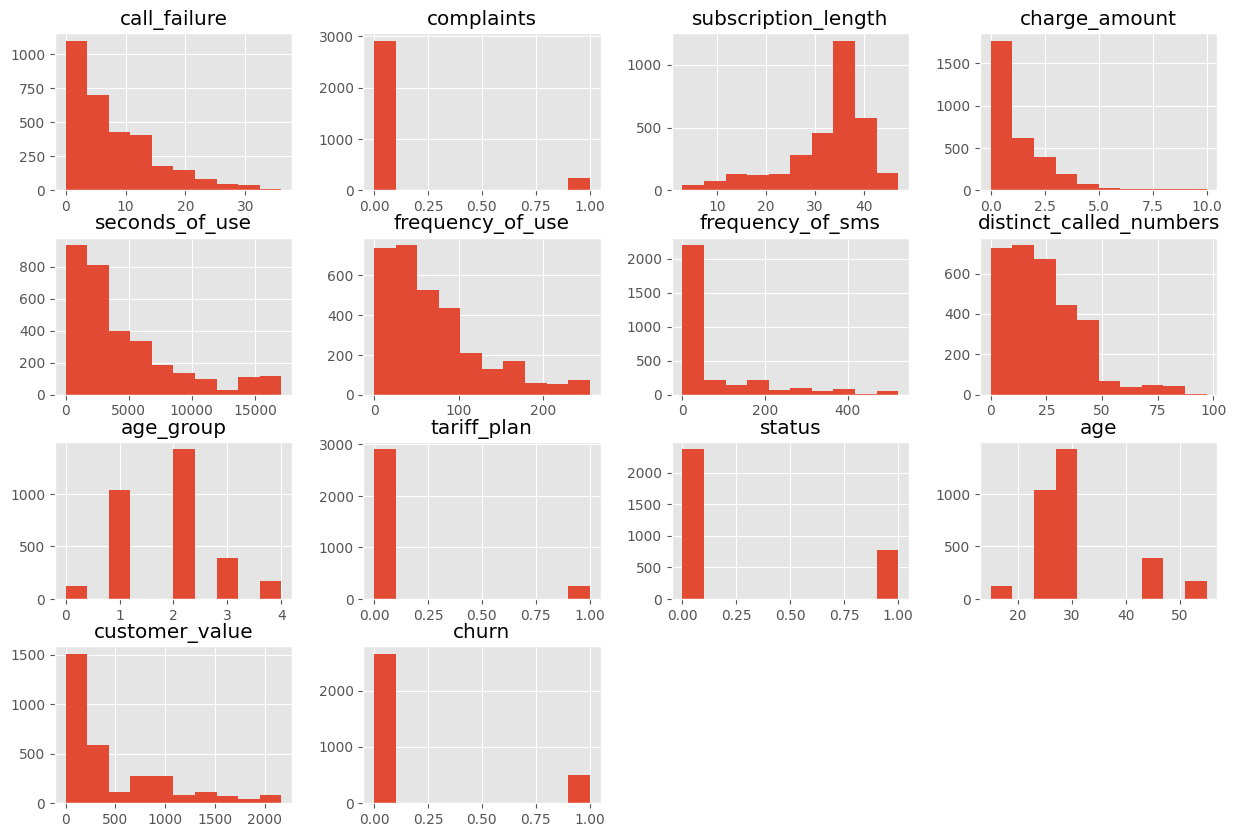

In [ ]:
# Overall distribution of all features:
df.hist(bins=10, figsize=(15, 10))
plt.show()

To obtain a better understanding of these features' contribution to the eventual churning decision, we plot and compare the feature distributions for churned and non-churned customers separately.

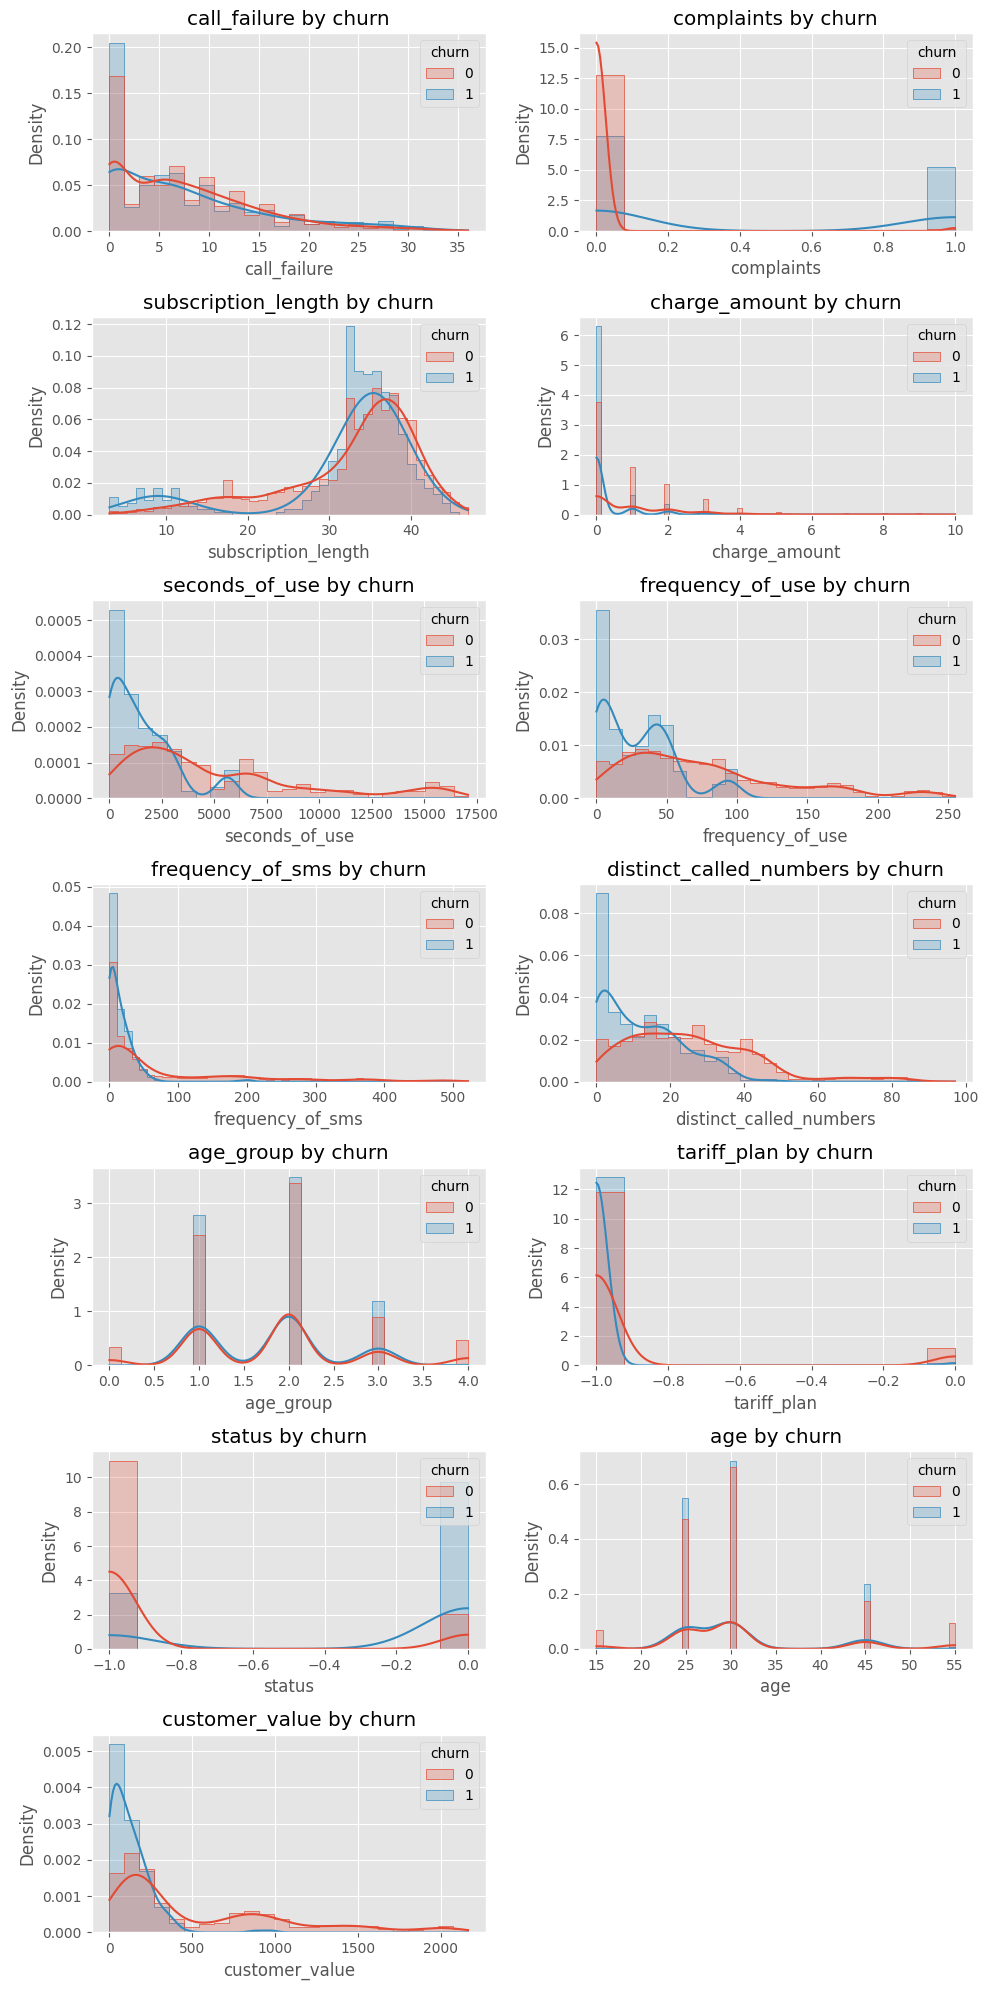

In [ ]:
# Plotting distribution of features by churn status
plt.figure(figsize=(10,20))
for i, feature in enumerate(numeric_features[:-1]):
    plt.subplot(7, 2, i+1)
    sns.histplot(df, x=feature, hue='churn', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"{feature} by churn")

plt.tight_layout()
plt.show()

#### Correlation analysis

At a surface level, we visualize the correlation between each pair of features in a heatmap to see their relationships.

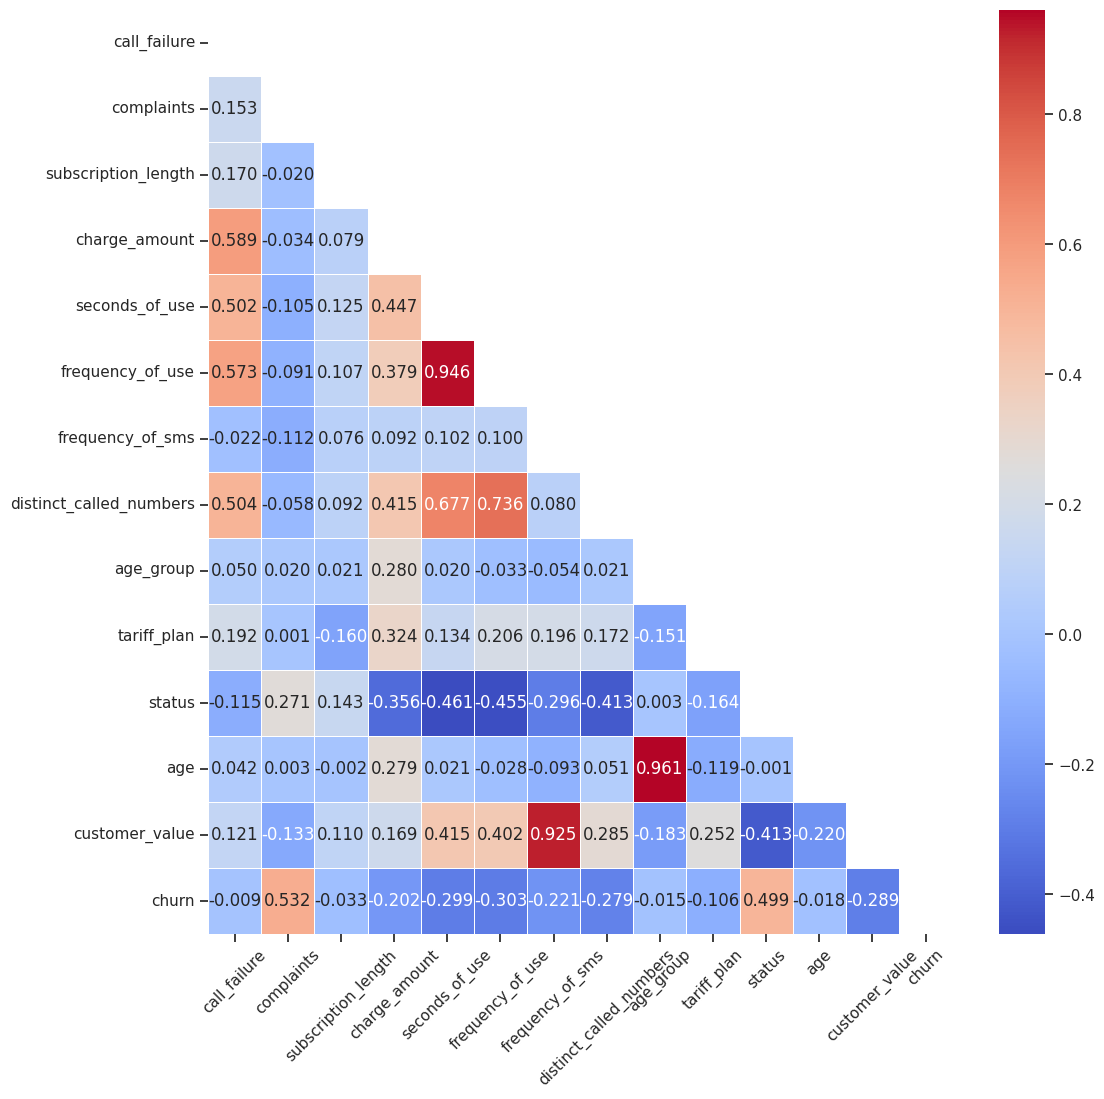

In [ ]:
plt.figure(figsize=(12,12))

mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.7)
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.show()

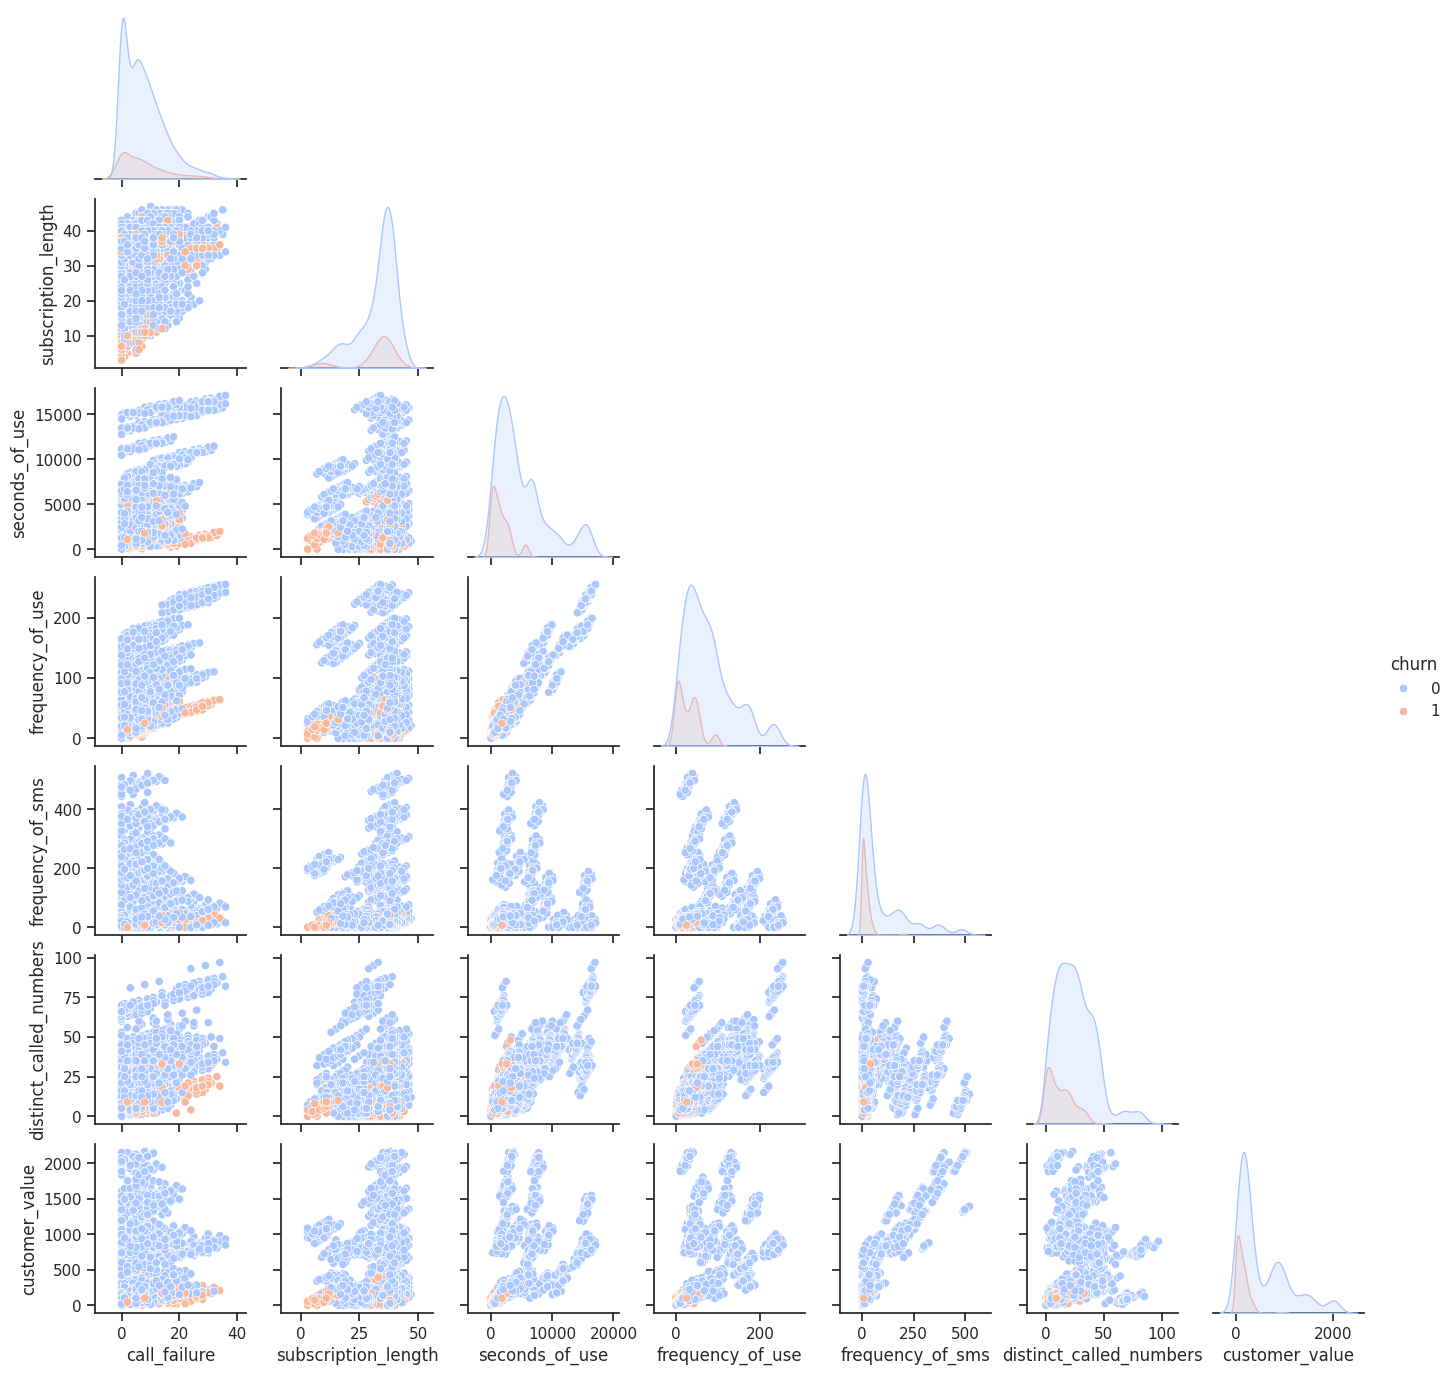

In [ ]:
# Pairplot for continuous variables:
indx = [0, 2, 4, 5, 6, 7, 12, 13]
cont_feature = [numeric_features[i] for i in indx]

sns.set(style="ticks")
sns.pairplot(data = df[cont_feature], palette='coolwarm', hue='churn', hue_order=[0,1], corner=True, height=2)


The frequencey and seconds of usage, and customer value and frequency of use are highly correlated. Considering the usage frequency and time capture slighly different aspects of the customer use pattern, and the calculation of the customer value is not clearly detailed, I decided to include these features in the following modelling processes, as the primary goal is to develop a good prediction model, rather than estalishing inference of specific features. Hence, multicollinearity is less of a concern here.

However, we spotted that `age` and `age_group` are equivalent features with a 1-to-1 relationship. Hence, we'll drop `age_group` in subsequent modeling.

<Axes: xlabel='age', ylabel='age_group'>

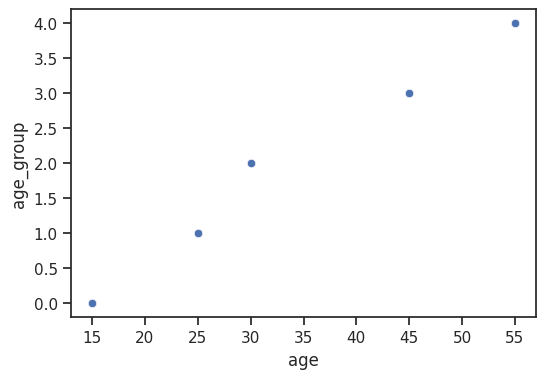

In [ ]:
# Age vs. Age Group
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='age', y='age_group')

## 2. Predicting Churn Status


### 2.1 Model Construction and Selection

**Model Selection**: We employed 7 models (Logistic Regression, Decision Trees, Random Forest, SVM, Gradient Boosting, XGBoost, and Neural Networks) to predict the binary churn labels based on the 12 features of training data.

- The entire data set is randomly split into training and testing sets with an 4:1 ratio using stratified sampling to ensure balanced label distribution.
- Skewed features are log-transformed, and numerical features are scaled post-split for unbiased evaluation.
- A 5-fold cross validation (again, with stratified sampling) is used to provide a robust evaluation of model performance and help mitigate overfitting.

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Drop the 'age_group' column due to high correlation with 'age'
df2 = df.copy()
df2 = df2.drop(columns=['age_group'])

# Apply log transformation to skewed features
df2['seconds_of_use'] = df2['seconds_of_use'].apply(lambda x: np.log1p(x))
df2['frequency_of_use'] = df2['frequency_of_use'].apply(lambda x: np.log1p(x))
df2['frequency_of_sms'] = df2['frequency_of_sms'].apply(lambda x: np.log1p(x))
df2['customer_value'] = df2['customer_value'].apply(lambda x: np.log1p(x))

# Define features and target variable
X = df2.drop(columns=['churn'])
y = df2['churn']

scaled_features = ['call_failure', 'subscription_length', 'seconds_of_use', 'frequency_of_use', 'frequency_of_sms', 'distinct_called_numbers', 'age', 'customer_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)

scaler = StandardScaler()
X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])
X_test[scaled_features] = scaler.transform(X_test[scaled_features])


# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=18),
    'Decision Tree': DecisionTreeClassifier(random_state=18),
    'SVM': SVC(probability=True, random_state=18),
    'Gradient Boosting': GradientBoostingClassifier(random_state=18),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=18),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=18)
}

cv_specs = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# Train and evaluate each model in a cross-validation scheme
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv = cv_specs, scoring='roc_auc')
    print(f"{name} - AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Logistic Regression - AUC: 0.9312 ± 0.0049
Random Forest - AUC: 0.9785 ± 0.0053
Decision Tree - AUC: 0.8904 ± 0.0174
SVM - AUC: 0.9578 ± 0.0040
Gradient Boosting - AUC: 0.9749 ± 0.0054
XGBoost - AUC: 0.9821 ± 0.0041
Neural Network - AUC: 0.9811 ± 0.0041


In [ ]:
for name, model in models.items():
    cv_scores_acc = cross_val_score(model, X_train, y_train, cv = cv_specs, scoring='accuracy')
    print(f"{name} - Accuracy: {np.mean(cv_scores_acc):.4f} ± {np.std(cv_scores_acc):.4f}")

print("\n")

for name, model in models.items():
    cv_scores_acc = cross_val_score(model, X_train, y_train, cv = cv_specs, scoring='balanced_accuracy')
    print(f"{name} - BA: {np.mean(cv_scores_acc):.4f} ± {np.std(cv_scores_acc):.4f}")

Logistic Regression - Accuracy: 0.8937 ± 0.0053
Random Forest - Accuracy: 0.9500 ± 0.0055
Decision Tree - Accuracy: 0.9337 ± 0.0061
SVM - Accuracy: 0.9246 ± 0.0110
Gradient Boosting - Accuracy: 0.9405 ± 0.0070
XGBoost - Accuracy: 0.9599 ± 0.0097
Neural Network - Accuracy: 0.9520 ± 0.0083


Logistic Regression - BA: 0.7582 ± 0.0172
Random Forest - BA: 0.8810 ± 0.0123
Decision Tree - BA: 0.8734 ± 0.0138
SVM - BA: 0.8125 ± 0.0257
Gradient Boosting - BA: 0.8651 ± 0.0250
XGBoost - BA: 0.9147 ± 0.0218
Neural Network - BA: 0.8967 ± 0.0274



Summary of Model Evaluation Results:

|   Model | Accuracy | BA | AUC | Best Model
|-------|---------|-----|--------------------|---|
| **Logistic** | 0.8937  | 0.7582   | 0.9312
| **RF** | 0.9500 | 0.8810  | 0.9785
| **DT** | 0.9337  | 0.8734   | 0.8904
| **SVM** | 0.9246 | 0.8125   | 0.9578
| **Gradient Boosting** | 0.9405 | 0.8651  | 0.9749   |
| **XGBoost** | 0.9599 | 0.9147  | 0.9821 |$\checkmark$ |*italicized text*
| **NN** | 0.9520  | 0.8967  | 0.9811



### 2.2 Model Optimization and Evaluation

Based on initial results, XGBoost model performs the best in predicting unseen data.

We move forward with this candidate model for hyperparameter optimization.


In [ ]:
# Grid param for search
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [3, 4, 5],                # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1],    # Learning rate
    'subsample': [0.8, 0.9, 1.0],          # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 0.9],   # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition
    'min_child_weight': [1, 3, 5]          # Minimum sum of instance weight needed in a child
}

# XGBoost classifier defined
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='gpu_hist'  # use GPU for training (~ 1hr 20min)
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_specs,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", best_params)
print("Best AUC-ROC Score:", best_score)

# Output:
# Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
# Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
# Best AUC-ROC Score: 0.984486474240998

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best AUC-ROC Score: 0.984486474240998


In [ ]:
# Rebuild the XGBmodel with best parameters
best_params = {
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 300,
    'subsample': 0.9
}

xgb_best = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params,
    random_state=42
)

# Train the model on the training set
xgb_best.fit(X_train, y_train)

# Final evaluation the model on the *test* set
y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]

print("Classification result on the test set:\n", classification_report(y_test, y_pred))
print("AUC on the test set:", roc_auc_score(y_test, y_proba), "\n")

print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))

Classification result on the test set:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       531
           1       0.90      0.82      0.86        99

    accuracy                           0.96       630
   macro avg       0.93      0.90      0.92       630
weighted avg       0.96      0.96      0.96       630

AUC on the test set: 0.9927904278186764 

Confusion matrix: 
 [[522   9]
 [ 18  81]]


In [ ]:
# Save the model to a file in binary format
%pwd

xgb_best.save_model('xgbmodel.bst')
print("Model saved successfully in XGBoost format!")

Model saved successfully in XGBoost format!


### 2.3 Visualization of Model Improvements

In [ ]:
# Original xgb model:
xgb_original = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=18)

xgb_original.fit(X_train, y_train)

# Evaluate the original model on the test set
y_pred_original = xgb_original.predict(X_test)
y_proba_original = xgb_original.predict_proba(X_test)[:, 1]

fpr_original, tpr_original, thre_original = roc_curve(y_test, y_proba_original)


# Worst model: Logistic regression:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

fpr_worst, tpr_worst, thre_worst = roc_curve(y_test, y_proba_logreg)

roc_original = roc_auc_score(y_test, y_proba_original)
roc_logreg = roc_auc_score(y_test, y_proba_logreg)

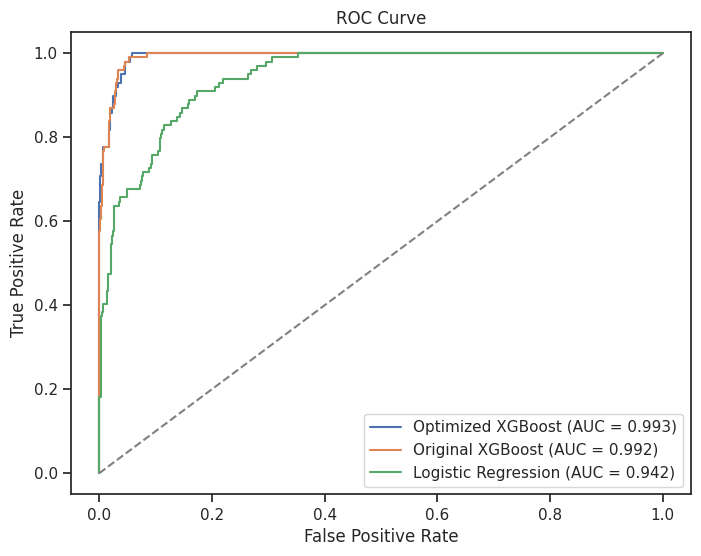

In [ ]:
# y_pred, y_proba are from xgb_best model
# Compute the ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Get ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Optimized XGBoost (AUC = {roc_auc:.3f})')
plt.plot(fpr_original, tpr_original, label=f'Original XGBoost (AUC = {roc_original:.3f})')
plt.plot(fpr_worst, tpr_worst, label=f'Logistic Regression (AUC = {roc_logreg:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 2.4 Feature Intepretation (SHAP)

Finally, we use the SHAP (SHapley Additive exPlanations) analysis, which is a game theoretic approach to explain the output of any machine learning model, to understand features' contribution to the final churn prediction in the XGBoost model.

In [ ]:
import shap

explainerModel = shap.TreeExplainer(xgb_best)

# Calculate the SHAP values
shap_values = explainerModel(X_test)

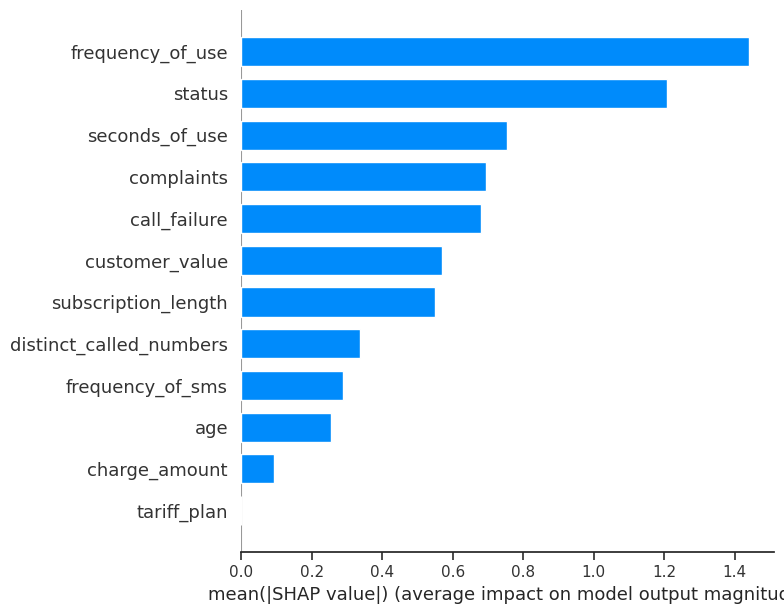

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

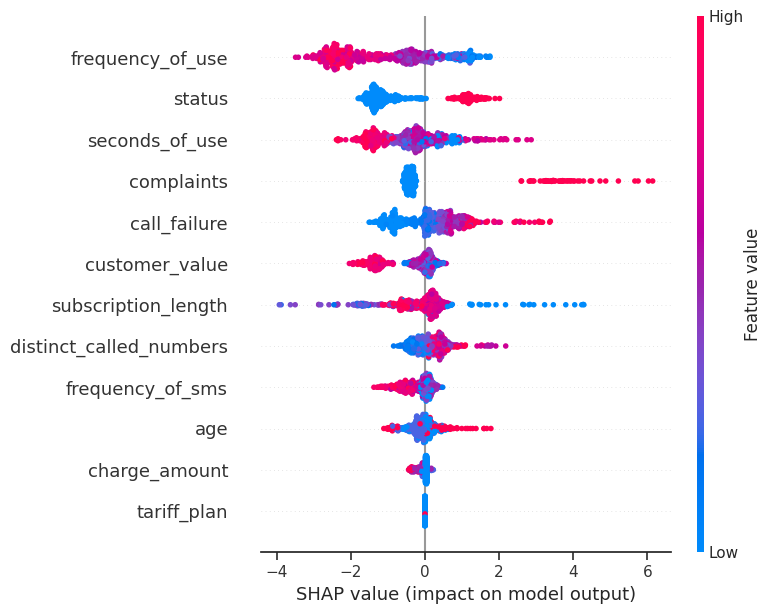

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.initjs()

sindex = 0 # any instance/prediction

# SHAP force plot for the s_index-th instance in the test set
shap.force_plot(explainerModel.expected_value, shap_values[sindex], X_test.iloc[sindex])

The **SHAP** analysis has provided some key insights into the features affecting customer churn and those that have little to no impact:

**Factors Affecting Churn:**

1. **Longer and More Frequent Calls**: Customers with heavier call usage are the primary contributor to a smaller likelihood to churn, as indicated by negative SHAP values. These customers are more engaged with the service.

2. **Customer Status**: Active customers are less likely to churn, with negative SHAP values pushing the outcome towards the non-churn (0) direction. This highlights the importance of maintaining customer engagement.

3. **Complaints** and **Call Failures**: Although less prominent, these features still play a role. Positive SHAP values for customers who have lodged complaints and/or experienced more call failures suggest a higher likelihood of churn, highlighting the need for effective issue resolution.

**Factors Not Affecting Churn:**

1. **Tariff Plan**: Whether customers are on a pay-as-you-go or contractual plan had minimal impact on the likelihood of churn, as shown by the around 0 SHAP value. This indicates that plan type does not significantly influence churn behavior in this dataset.

2. **Charge Amount**: Surprisingly, charge amount does not significantly impact churn status, suggesting that the monthly fee or plan cost is not a primary factor in customers' decisions to stay or leave.


In summary, our XGBoost model and the accompanying SHAP analysis emphasize the critical role of customer engagement, service quality, and complaint management in retaining customers. Additionally, the analysis indicates that certain factors, such as tariff plan type and charge amount, have little to no effect on churn, providing valuable insights for business strategy.

## 3. Conclusion

In this project, we aimed to address the challenge of predicting customer churn for a telecom company by employing a systematic approach from model construction, selection, optimization, to interpretation. Through the use of various machine learning models, including Logistic Regression, Decision Trees, Random Forest, SVM, Gradient Boosting, XGBoost, and Neural Networks, we identified XGBoost as the most effective model for this task and data.

### Model Performance and Optimization

The XGBoost model, initially selected based on its superior performance in multiple metrics during cross-validation, was further optimized using `GridSearchCV`. This fine-tuning process yielded the best hyperparameters, leading to a final model that demonstrated an impressive AUC-ROC score of 0.993 on the test set. This optimized model slightly outperformed the original XGBoost model and other models, validating the effectiveness of the hyperparameter tuning process.


### Feature Interpretation with SHAP

To enhance the interpretability of the model, SHAP values were derived from the optimized XGBoost model on the test data, to understand the impact of individual features on churn predictions. In short, we found that:

- **Longer and more frequent call use** of telecom services significantly reduces the likelihood of churn.
- **Active customer status** is a strong indicator of customer retention.
- **Complaints** and **call failures** increase the risk of churn, albeit to a lesser extent.
- **Tariff plan type** and **charge amount** were found to have minimal impact on churn.

### Business Insights about customer retaining

We can extract several actionable insights based on the SHAP analysis:

1. **Customer Engagement**:
   - Target frequent users and maintain customer activity through potential loyalty programs and/or personalized service packages to reduce churn.

2. **Proactive Issue Resolution**:
   - Ensure effective customer service strategies to address complaints quickly, reducing the risk of churn.

3. **Service Quality**:
   - Focus on improving service quality, particularly minimizing call failures, to further decrease churn rates.

4. **Plan Type and Pricing**:
   - Since tariff plan type and charge amount have little impact on churn, the company shall prioritize other customer engagement-centered strategies and service quality (both tele-service and customer service) over pricing adjustments or plan structure.


### Final Words

This project highlights the importance of combining model performance optimization with interpretability to generate actionable business insights. The use of XGBoost, coupled with SHAP analysis, not only provided a highly accurate predictive model but also offered clear guidance on how to effectively help the telecom company on customer retention. The insights and suggestions from this project might also be valuable in other similar challenges or industries.